## 线性回归，从零开始实现

只使用张量和自动求导，从零开始实现整个方法， 包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。

In [1]:
import random
import torch
import matplotlib.pyplot as plt

### 1.构造人造数据集

$\mathbf{w} = [2,-3.4]^T, ~ b=4.2, ~ \epsilon \sim \mathcal{N}(0, 0.01), ~ \mathbf{y} = \mathbf{X}\mathbf{w} + b + \epsilon$

In [4]:
def synthetic_data(w, b, num_examples):
    '''生成 y = Xw + b + 高斯噪声'''
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    print(y.shape)
    y += torch.normal(0, 0.01, y.shape)
    print(y.shape)
    return X, y.reshape((-1, 1))                # matmul后，降维了，需要reshape成二维的，方便后面算loss

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

torch.Size([1000])
torch.Size([1000])


features: tensor([-0.3033,  1.2689]) 
label: tensor([-0.7253])


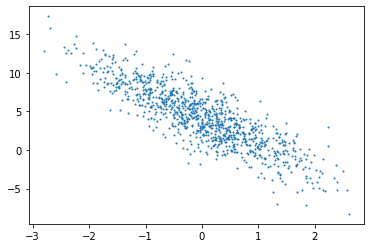

In [6]:
print('features:', features[0], '\nlabel:', labels[0])
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

### 2.读取数据集

In [7]:
def data_iter(batch_size, features, labels):
    '''构建随机取batch的生成器'''
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # 步长是batch_size
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        # yield类似于返回一个值，并记住返回的位置，下次就从这个位置后开始

In [8]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.7329,  0.7594],
        [-2.6526,  1.2573],
        [-1.0192,  2.0798],
        [ 2.1386,  0.3683],
        [ 1.1492, -0.9073],
        [-0.8156,  1.2827],
        [ 1.6058,  1.6586],
        [ 0.9546, -0.0510],
        [-0.1573,  1.6859],
        [-0.1433, -0.8668]]) 
 tensor([[ 5.0781],
        [-5.3954],
        [-4.9148],
        [ 7.2120],
        [ 9.5991],
        [-1.7850],
        [ 1.7747],
        [ 6.2862],
        [-1.8453],
        [ 6.8769]])
